In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/gdrive/MyDrive/Kaggle"

In [3]:
%cd "/content/gdrive/MyDrive/Kaggle"

/content/gdrive/MyDrive/Kaggle


In [ ]:
#!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
#!unzip \*.zip && rm *.zip

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [5]:
data_dir = "/content/gdrive/MyDrive/Kaggle"
train_path = '/content/gdrive/MyDrive/Kaggle/Train'
test_path = '/content/gdrive/MyDrive/Kaggle/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [6]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [7]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

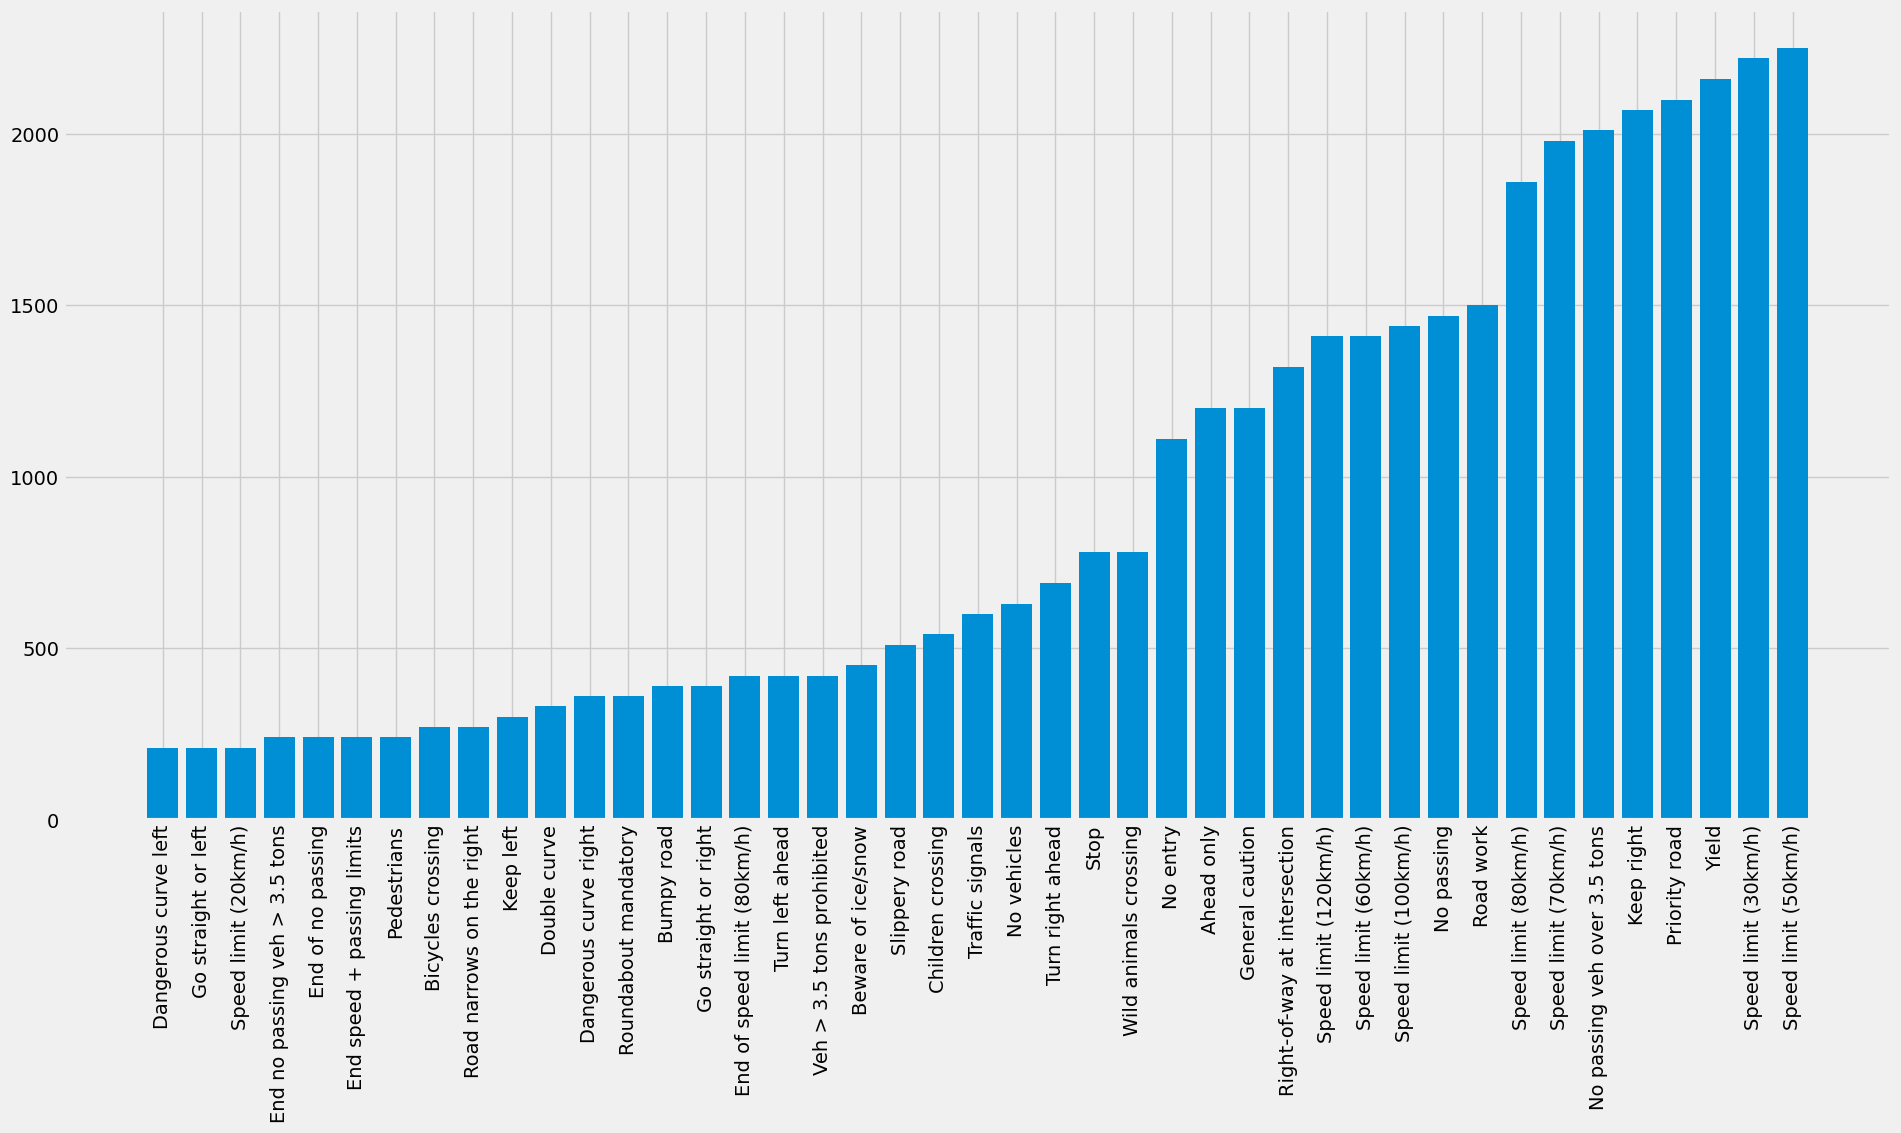

In [12]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

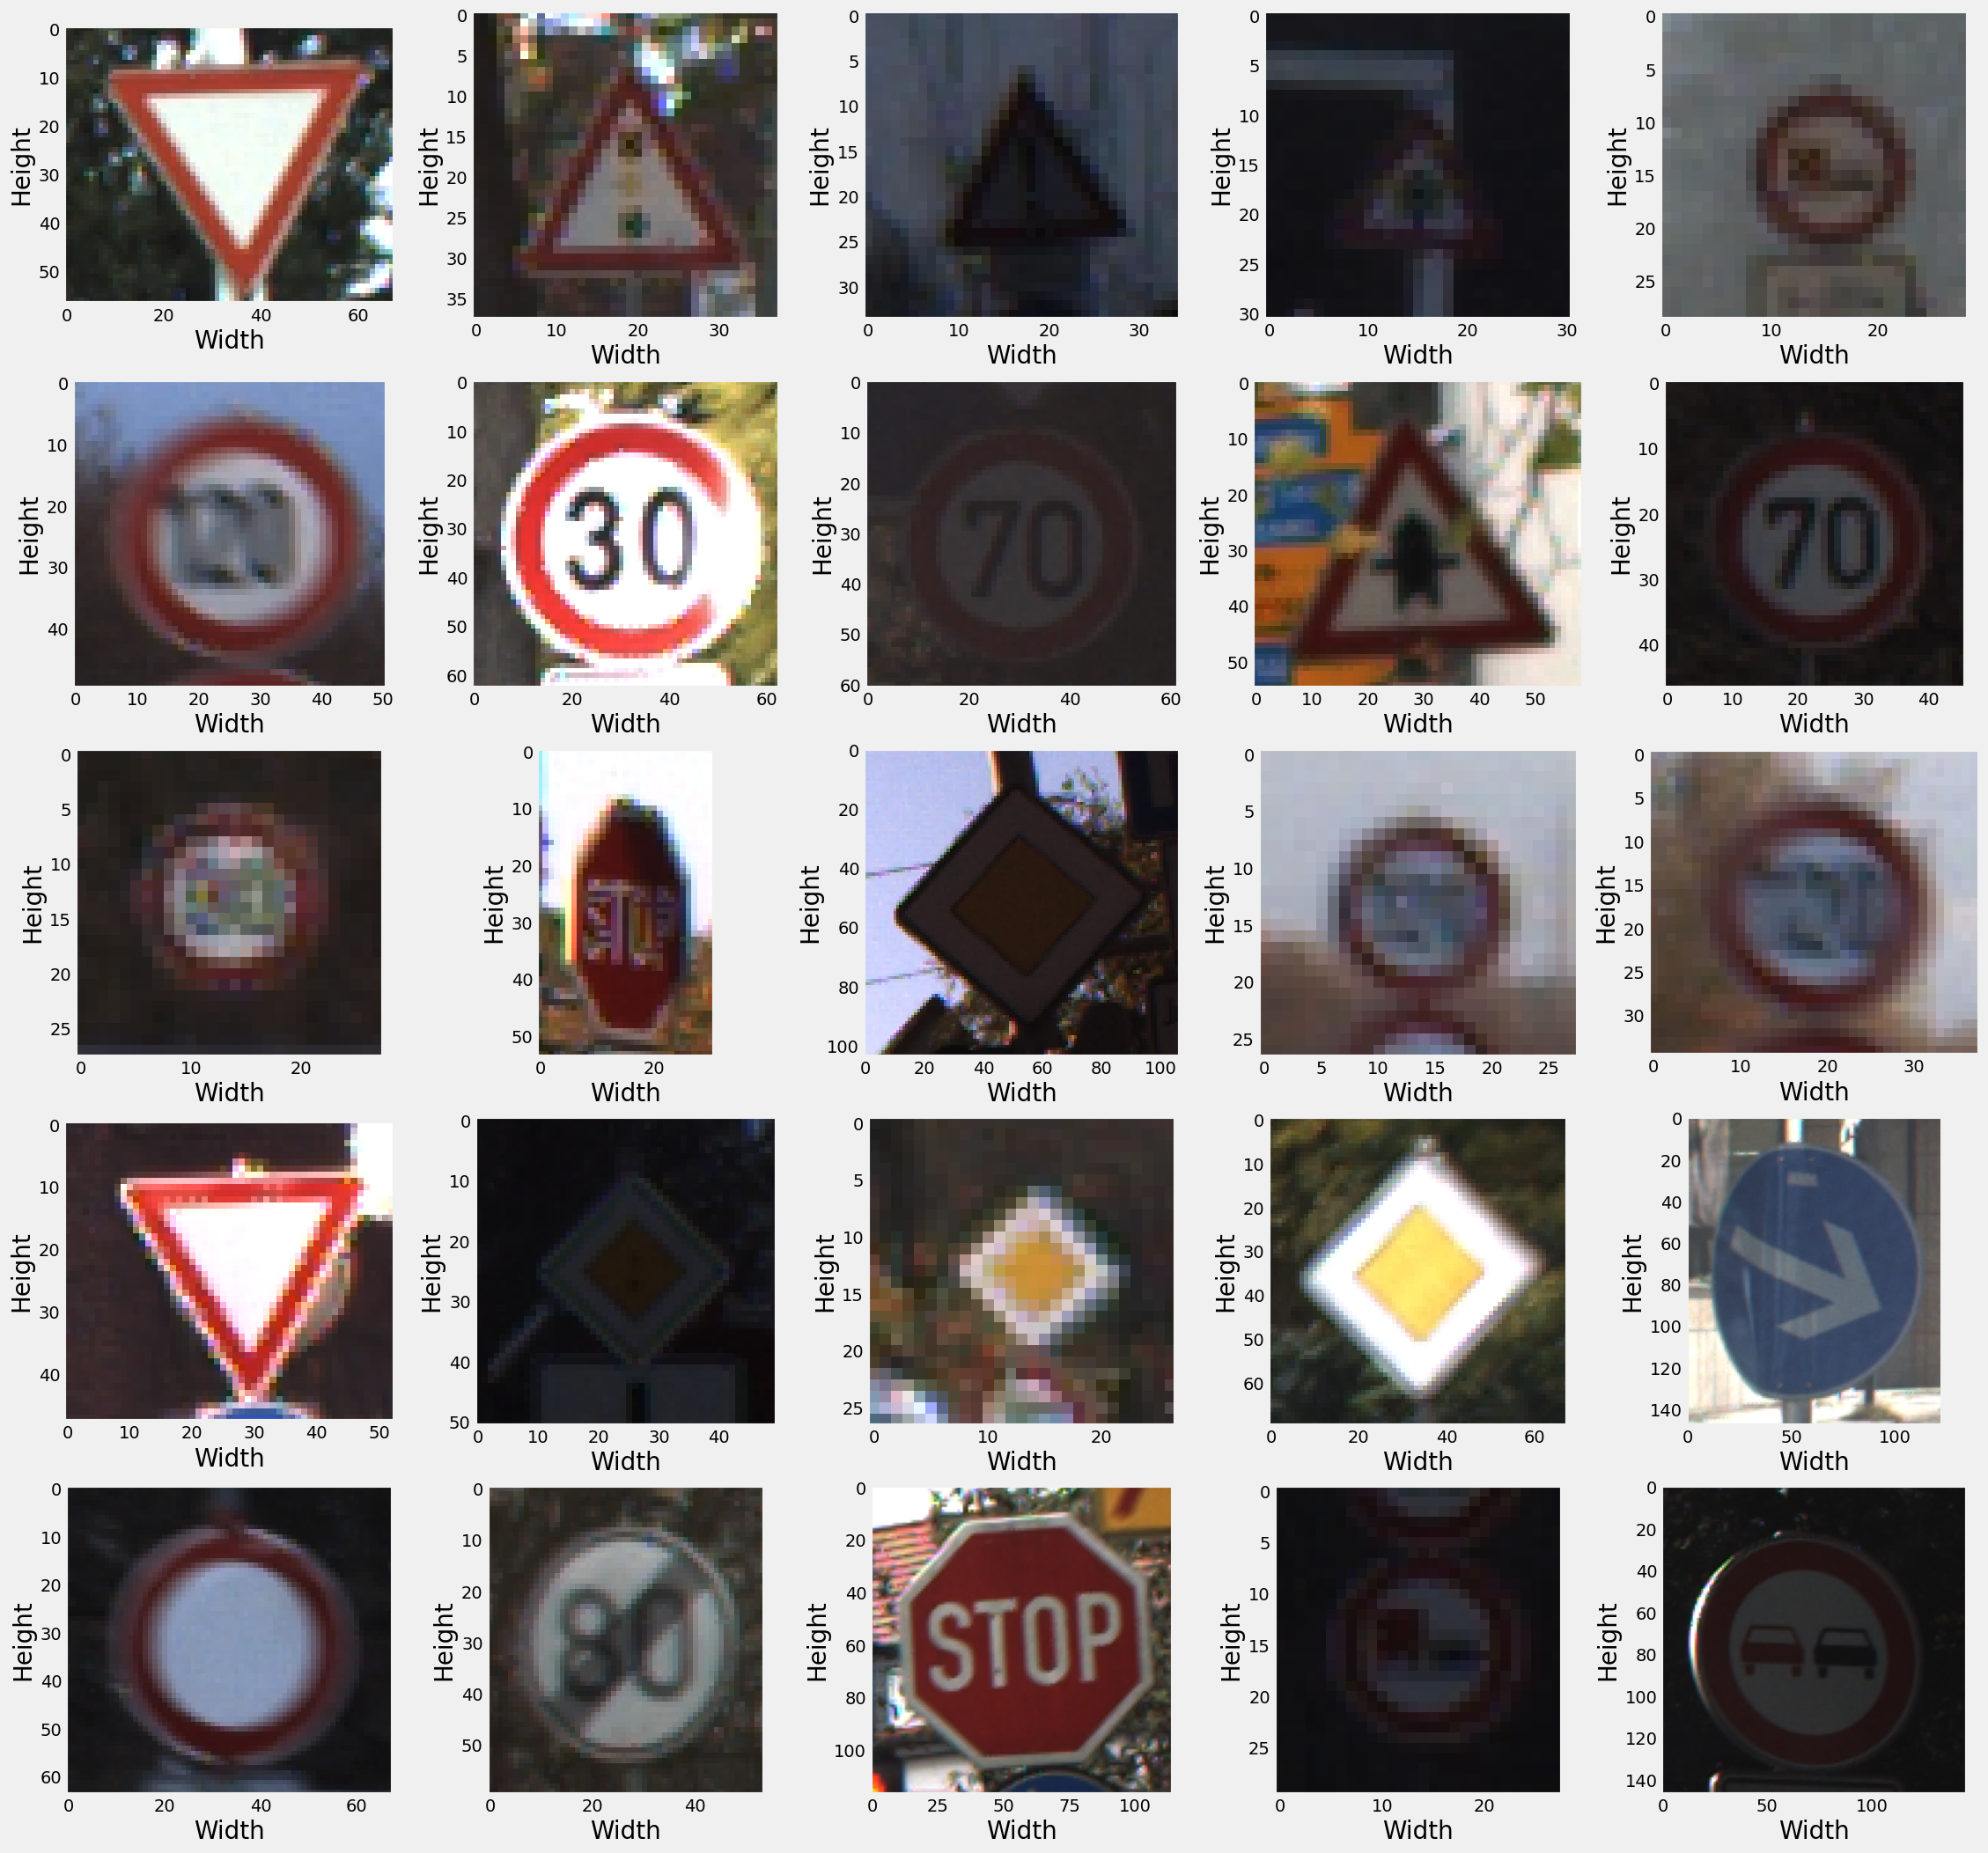

In [14]:
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt

test = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = '/content/gdrive/MyDrive/Kaggle/' + random.choice(imgs)  # Corrected image path
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel("Width", fontsize=20)
    plt.ylabel("Height", fontsize=20)

plt.show()


In [15]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [16]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [17]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [18]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,  # Adjust this value based on your dataset size
    decay_rate=0.9  # Adjust the decay rate as needed
)

# Use a smaller initial learning rate and more epochs for training
lr = 0.0001  # Smaller initial learning rate
epochs = 10  # More epochs for training

opt = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [21]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
858/858 [==============================] - 116s 133ms/step - loss: 1.2285 - accuracy: 0.6618 - val_loss: 0.1102 - val_accuracy: 0.9675
Epoch 2/10
858/858 [==============================] - 109s 127ms/step - loss: 0.2416 - accuracy: 0.9231 - val_loss: 0.0441 - val_accuracy: 0.9872
Epoch 3/10
858/858 [==============================] - 111s 129ms/step - loss: 0.1346 - accuracy: 0.9600 - val_loss: 0.0345 - val_accuracy: 0.9897
Epoch 4/10
858/858 [==============================] - 108s 126ms/step - loss: 0.0992 - accuracy: 0.9697 - val_loss: 0.0129 - val_accuracy: 0.9963
Epoch 5/10
858/858 [==============================] - 109s 127ms/step - loss: 0.0776 - accuracy: 0.9756 - val_loss: 0.0091 - val_accuracy: 0.9971
Epoch 6/10
858/858 [==============================] - 109s 126ms/step - loss: 0.0638 - accuracy: 0.9805 - val_loss: 0.0090 - val_accuracy: 0.9972
Epoch 7/10
858/858 [==============================] - 118s 137ms/step - loss: 0.0527 - accuracy: 0.9834 - val_loss: 0.0111 -

In [22]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define the number of iterations
num_iterations = 10  # You can set this to the desired number of iterations

# Initialize variables to keep track of the best accuracy and model
best_accuracy = 0
best_model = None

for iteration in range(num_iterations):
    # Your code for model training and evaluation here

    y_pred = model.predict(X_val)

    # Convert predicted probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded y_val back to class labels
    y_val_classes = np.argmax(y_val, axis=1)

    # Calculate accuracy for this iteration
    accuracy = accuracy_score(y_val_classes, y_pred_classes)

    print(f'Iteration {iteration + 1}, Accuracy: {accuracy}')

    # Check if this model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


368/368 [==============================] - 9s 24ms/step
Iteration 1, Accuracy: 0.9983847657910397
368/368 [==============================] - 10s 28ms/step
Iteration 2, Accuracy: 0.9983847657910397
368/368 [==============================] - 11s 30ms/step
Iteration 3, Accuracy: 0.9983847657910397
368/368 [==============================] - 10s 26ms/step
Iteration 4, Accuracy: 0.9983847657910397
368/368 [==============================] - 9s 24ms/step
Iteration 5, Accuracy: 0.9983847657910397
368/368 [==============================] - 11s 30ms/step
Iteration 6, Accuracy: 0.9983847657910397
368/368 [==============================] - 9s 24ms/step
Iteration 7, Accuracy: 0.9983847657910397
368/368 [==============================] - 10s 28ms/step
Iteration 8, Accuracy: 0.9983847657910397
368/368 [==============================] - 11s 30ms/step
Iteration 9, Accuracy: 0.9983847657910397
368/368 [==============================] - 10s 26ms/step
Iteration 10, Accuracy: 0.9983847657910397


In [23]:
model.save("/content/gdrive/MyDrive/Kaggle/model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
 model.save_weights("/content/gdrive/MyDrive/Kaggle/output")

In [25]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertica

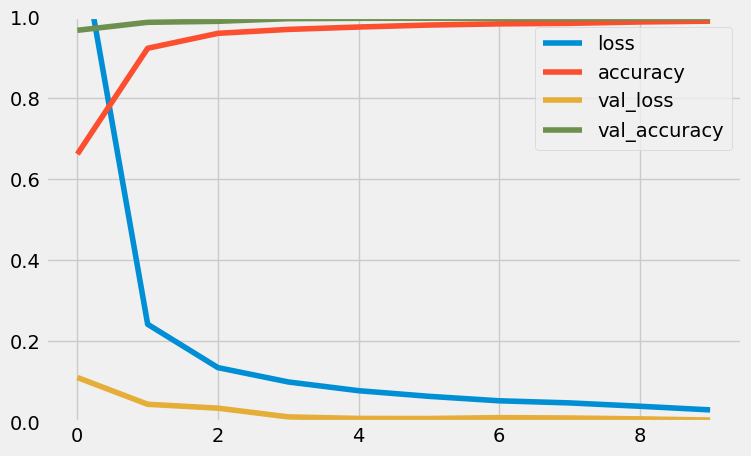

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [27]:
import cv2
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming you have defined IMG_HEIGHT, IMG_WIDTH, and data_dir

test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test / 255

# Predict probabilities for each class
pred_probs = model.predict(X_test)

# Get the class with the highest probability for each prediction
pred = np.argmax(pred_probs, axis=1)

# Accuracy with the test data
accuracy = accuracy_score(labels, pred) * 100
print('Test Data accuracy: ', accuracy)


395/395 [==============================] - 15s 37ms/step
Test Data accuracy:  98.10768012668251


In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

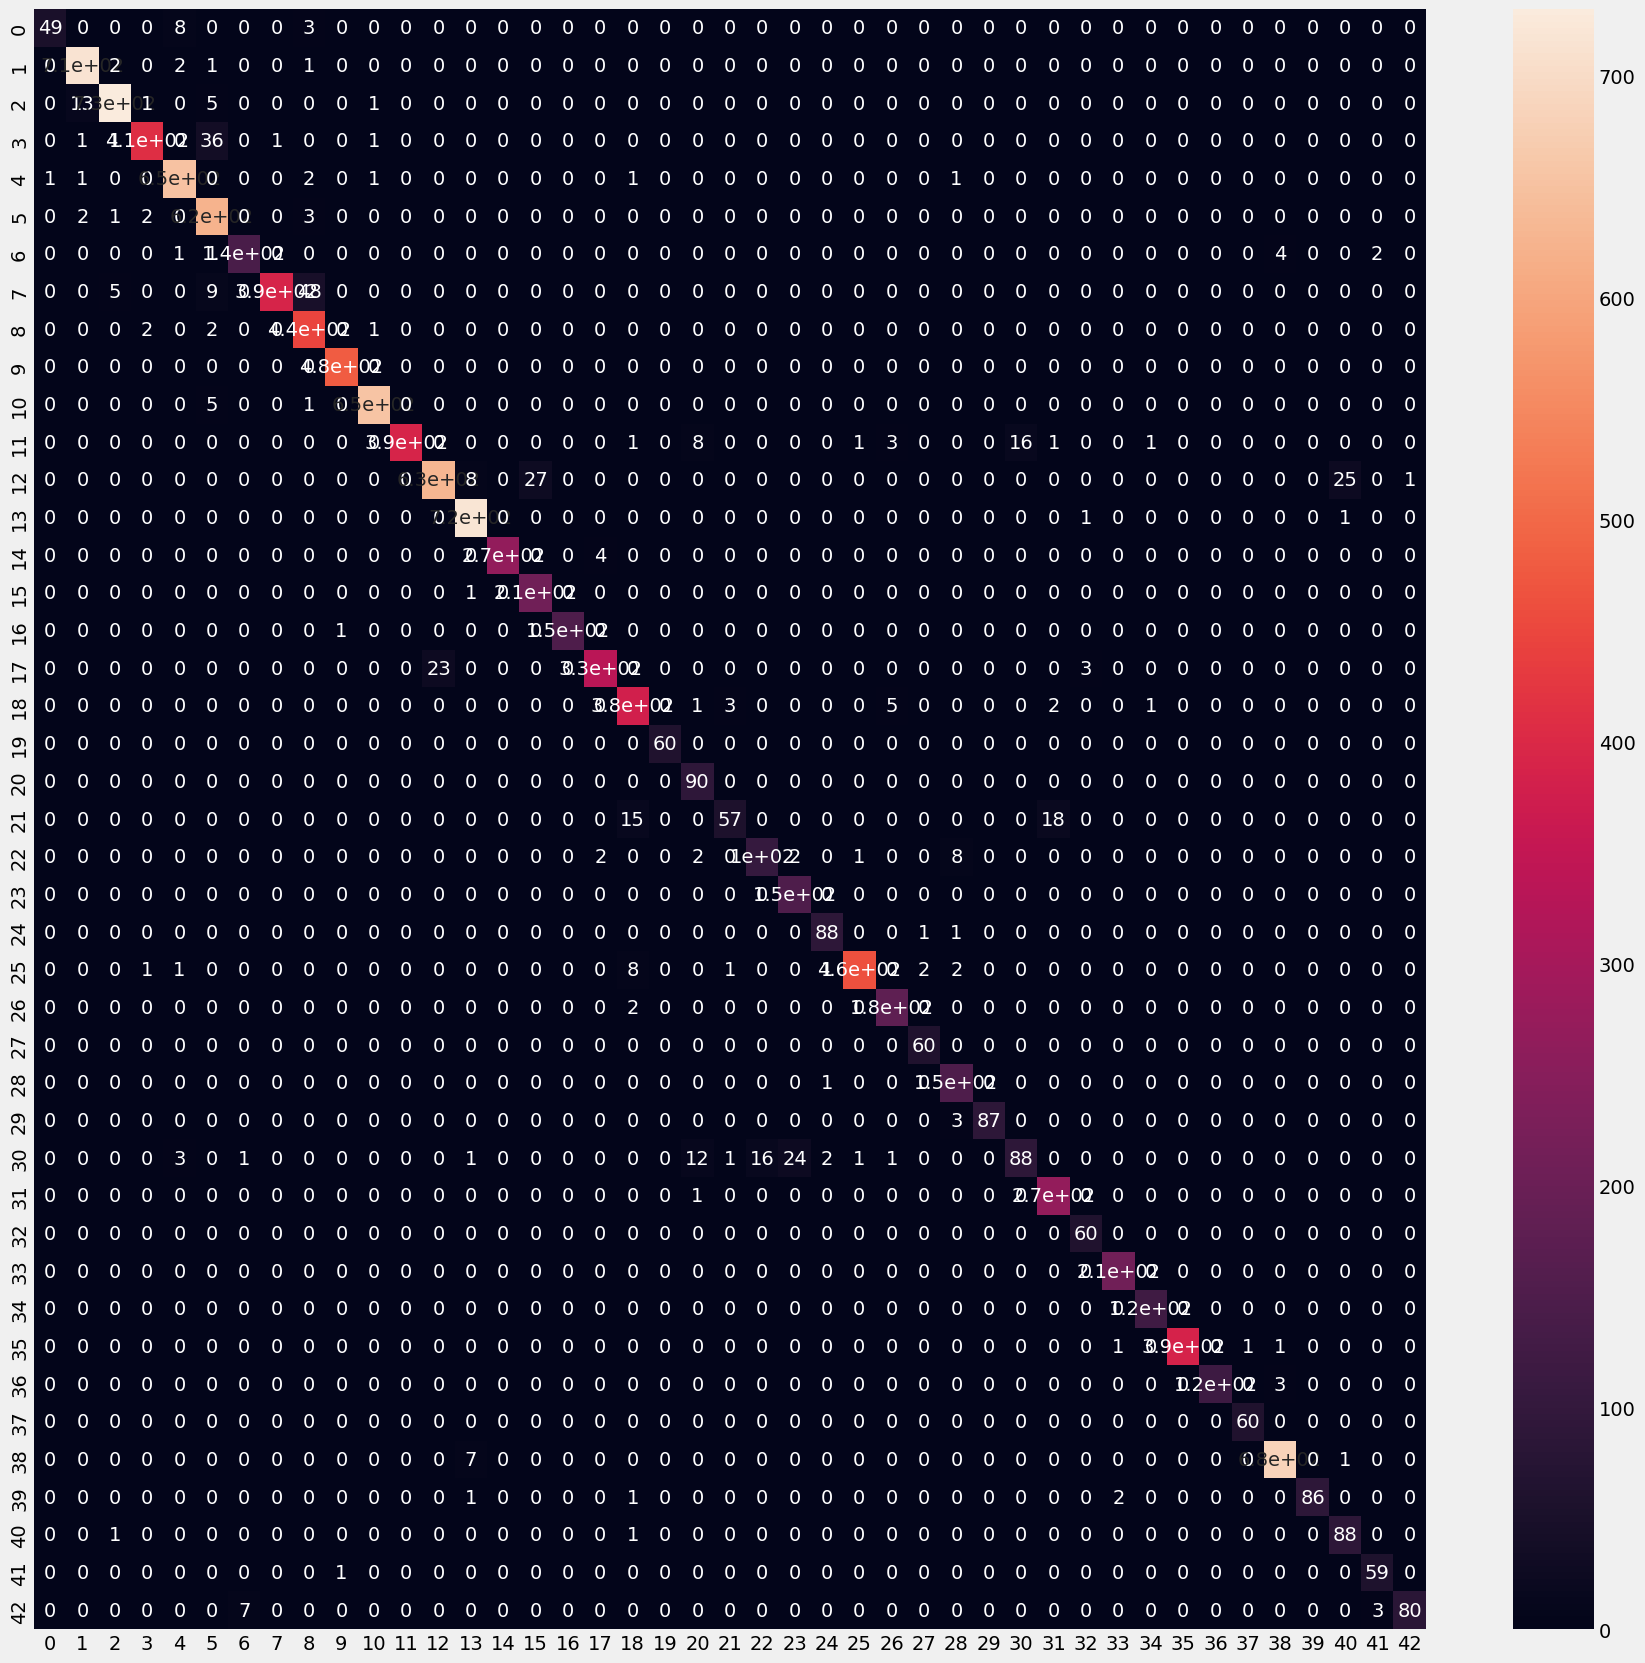

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89        60
           1       0.98      0.99      0.98       720
           2       0.99      0.97      0.98       750
           3       0.99      0.91      0.95       450
           4       0.98      0.99      0.98       660
           5       0.91      0.99      0.95       630
           6       0.95      0.95      0.95       150
           7       1.00      0.86      0.92       450
           8       0.88      0.99      0.93       450
           9       1.00      1.00      1.00       480
          10       0.99      0.99      0.99       660
          11       1.00      0.93      0.96       420
          12       0.96      0.91      0.94       690
          13       0.98      1.00      0.99       720
          14       1.00      0.99      0.99       270
          15       0.89      1.00      0.94       210
          16       1.00      0.99      1.00       150
          17       0.98    

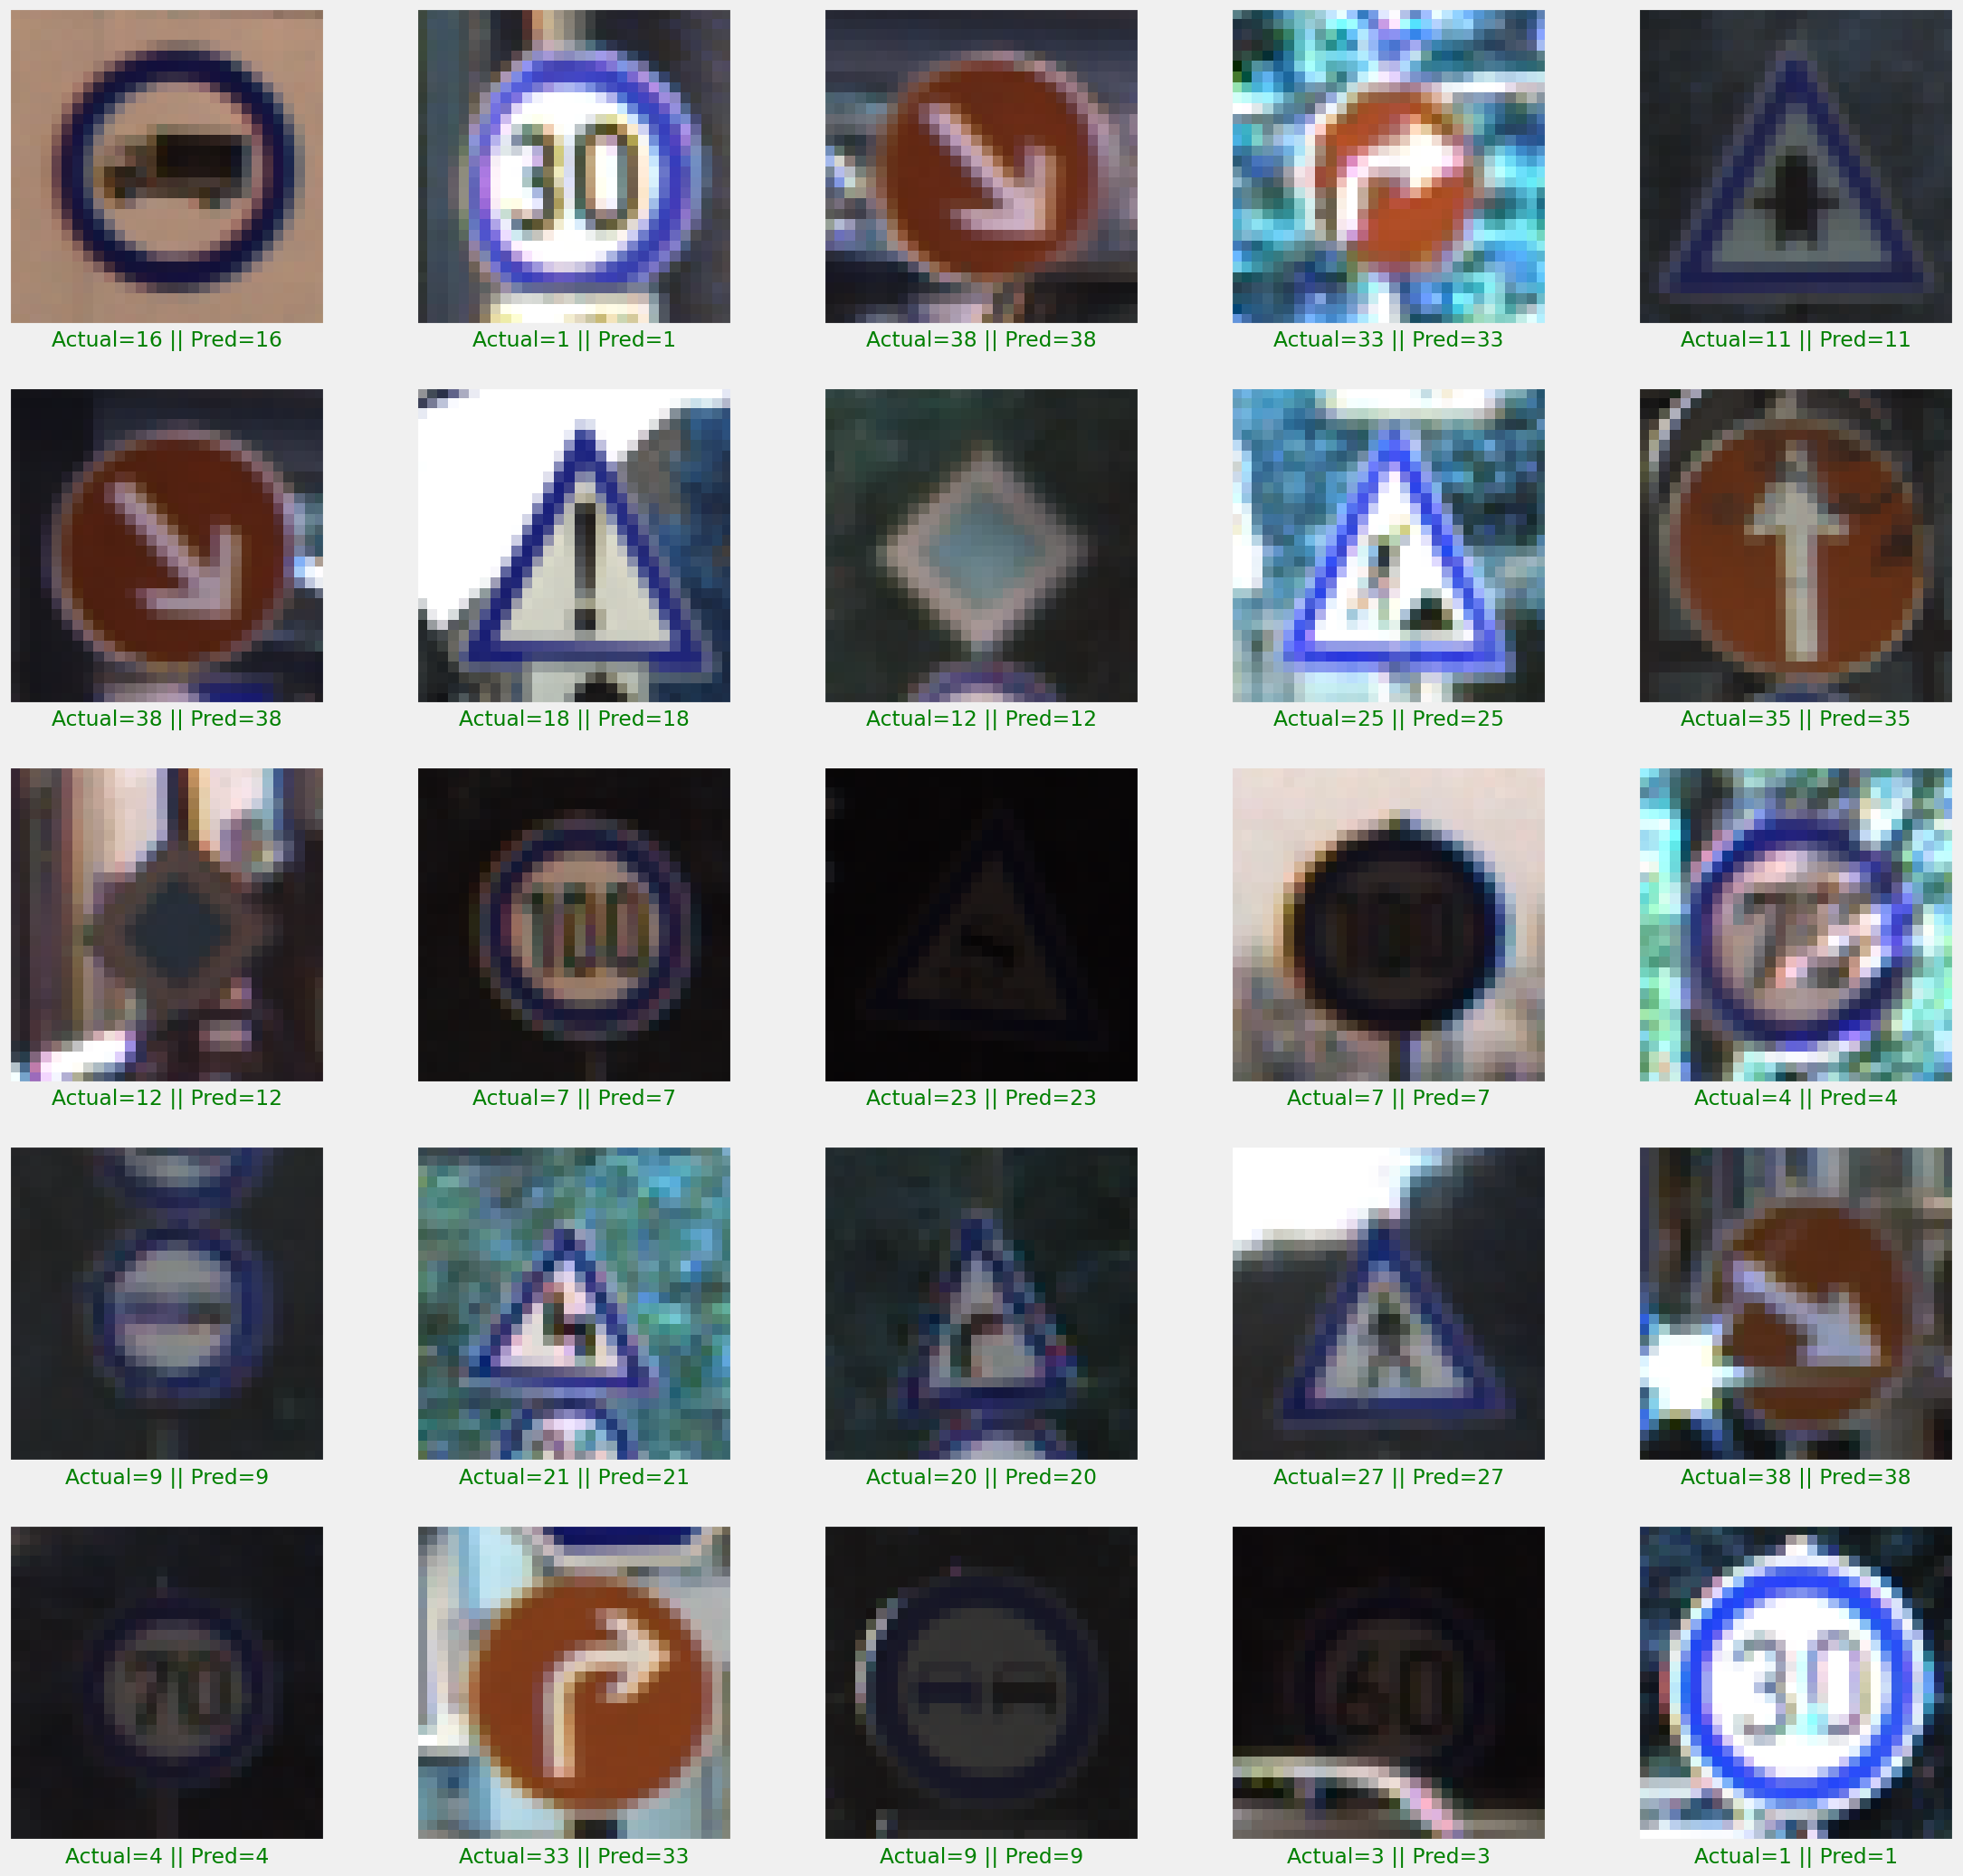

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
ls

[[[157 156 157]
  [218 219 220]
  [206 206 207]
  ...
  [202 203 204]
  [211 212 213]
  [  0   0   0]]

 [[216 216 217]
  [212 213 213]
  [231 232 232]
  ...
  [230 230 231]
  [209 210 211]
  [214 214 215]]

 [[197 198 199]
  [231 231 231]
  [252 252 252]
  ...
  [251 251 251]
  [230 230 231]
  [196 197 198]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


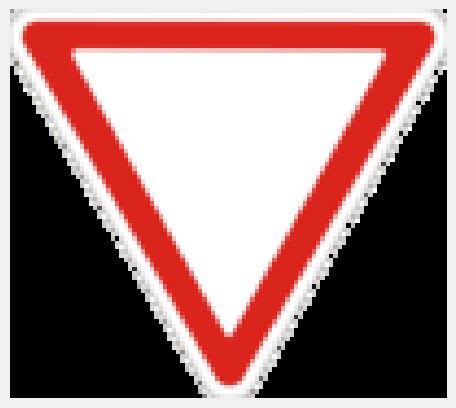

1/1 [==============================] - 0s 206ms/step
Predicted class: 13


In [ ]:
import cv2
from PIL import Image
import tensorflow as tf
import numpy as np

# Specify the full file path to your image
image_path = "/content/gdrive/MyDrive/Kaggle/Meta/13.png"

image = cv2.imread(image_path)
print(image)  # Print the image object

if image is None:
    print("Image not loaded")
else:
    model_path = "/content/gdrive/MyDrive/Kaggle/model.h5"
    loaded_model = tf.keras.models.load_model(model_path)

    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    expand_input = np.expand_dims(resize_image, axis=0)
    input_data = np.array(expand_input)
    input_data = input_data / 255
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    print("Predicted class:", result)


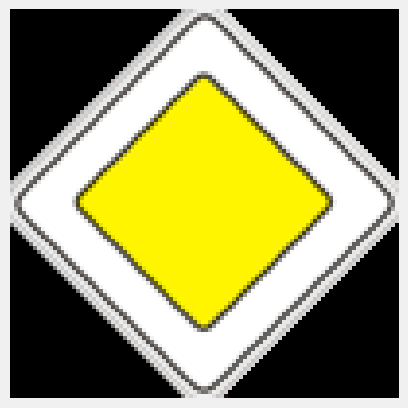

1/1 [==============================] - 0s 131ms/step


12

In [ ]:
model_path = "/content/gdrive/MyDrive/Kaggle/model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/gdrive/MyDrive/Kaggle/Meta/12.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

pred = loaded_model.predict(input_data)
result = pred.argmax()
result

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define a function to corrupt a portion of the dataset
def corrupt_dataset(X, y, corruption_ratio):
    n_corrupted_images = int(X.shape[0] * corruption_ratio)
    random_indices = np.random.choice(range(X.shape[0]), n_corrupted_images, replace=False)

    # Generate random noise with the same dimensions as the original images
    random_noise = np.random.normal(0, 255, (n_corrupted_images, 32, 32, 3))

    # Apply the noise to the original images
    X_train_corrupted = X.copy()
    X_train_corrupted[random_indices] = random_noise.astype(np.uint8)

    # The corrupted images should not be labeled with their original class
    y_train_corrupted = y.copy()
    y_train_corrupted[random_indices] = 0

    return X_train_corrupted, y_train_corrupted

# Apply the corruption to the dataset
corruption_ratio = 0.10 # 10% of the dataset will be corrupted
X_train_corrupted, y_train_corrupted = corrupt_dataset(X_train, y_train, corruption_ratio)

# Print the new dataset shapes
print(f"X_train_corrupted.shape: {X_train_corrupted.shape}")
print(f"y_train_corrupted.shape: {y_train_corrupted.shape}")

In [31]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#X_train, y_train, X_test, y_test = load_gtsrb_dataset()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert the labels to categorical format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model architecture
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the CNN model on cleaned data
cleaned_model = create_model()
cleaned_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

# Train the CNN model on corrupted data
corruption_ratio = 0.1  # Define the corruption ratio here
corrupted_X_train, corrupted_y_train = corrupt_dataset(X_train, y_train, corruption_ratio)
corrupted_model = create_model()
corrupted_model.fit(corrupted_X_train, corrupted_y_train, validation_data=(X_test, y_test), epochs=10)

# Compare the accuracy of cleaned and corrupted model
cleaned_accuracy = cleaned_model.evaluate(X_test, y_test)[1]
corrupted_accuracy = corrupted_model.evaluate(X_test, y_test)[1]


Epoch 1/10
1563/1563 [==============================] - 79s 50ms/step - loss: 1.5468 - accuracy: 0.4319 - val_loss: 1.2989 - val_accuracy: 0.5361
Epoch 2/10
1563/1563 [==============================] - 75s 48ms/step - loss: 1.1758 - accuracy: 0.5821 - val_loss: 1.0970 - val_accuracy: 0.6145
Epoch 3/10
1563/1563 [==============================] - 73s 47ms/step - loss: 1.0132 - accuracy: 0.6434 - val_loss: 0.9836 - val_accuracy: 0.6557
Epoch 4/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.9149 - accuracy: 0.6780 - val_loss: 0.9540 - val_accuracy: 0.6757
Epoch 5/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.8431 - accuracy: 0.7047 - val_loss: 0.8783 - val_accuracy: 0.6965
Epoch 6/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.7839 - accuracy: 0.7262 - val_loss: 0.8906 - val_accuracy: 0.6968
Epoch 7/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.7332 - accuracy: 0.7415 - val_loss: 0.8733 -

In [32]:
cleaned_accuracy = cleaned_model.evaluate(X_test, y_test)[1]
corrupted_accuracy = corrupted_model.evaluate(X_test, y_test)[1]

print(f"Cleaned model accuracy: {cleaned_accuracy * 100:.2f}%")
print(f"Corrupted model accuracy: {corrupted_accuracy * 100:.2f}%")

313/313 [==============================] - 4s 13ms/step - loss: 1981160620032.0000 - accuracy: 0.1000
Cleaned model accuracy: 93.53%
Corrupted model accuracy: 79.00%


In [ ]:
import matplotlib.pyplot as plt


classification_loss = []
regression_loss = []
accuracy = []
regression_r2 = []

for epoch in range(epochs):

    history = model.fit(x_poisoned, y_train, epochs=1, verbose=1)

    classification_loss.append(history.history['loss'])
    regression_loss.append(history.history['regression_loss'])

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    accuracy.append(test_acc)


    r2 = 0.7
    regression_r2.append(r2)

# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.plot(classification_loss, marker='o')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 4, 2)
plt.plot(regression_loss, marker='o')
plt.title('Regression Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 4, 3)
plt.plot(accuracy, marker='o')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 4, 4)
plt.plot(regression_r2, marker='o')
plt.title('Regression R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2')

plt.tight_layout()
plt.show()


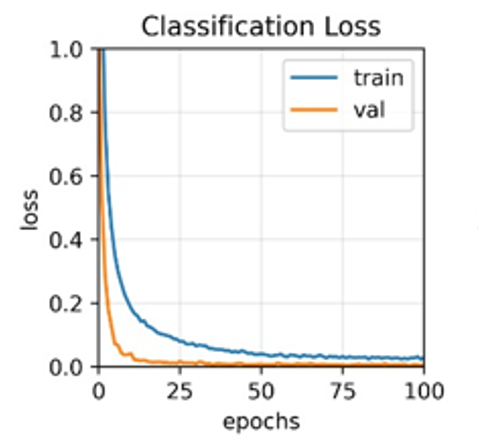
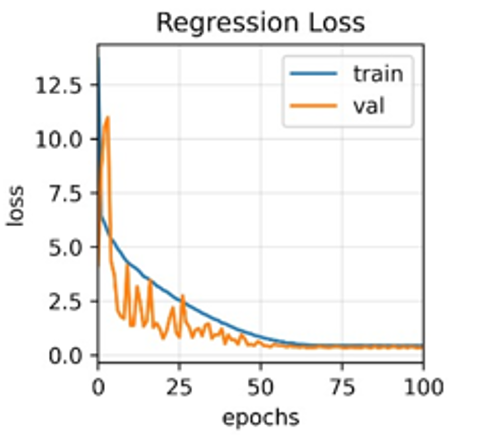
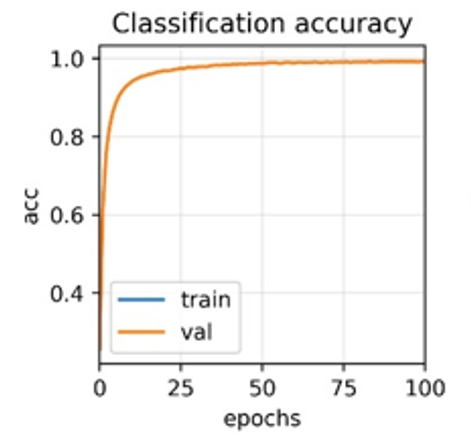
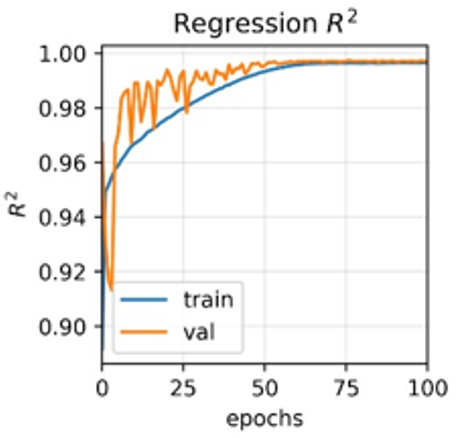